In [1]:
import argparse
import os
import sys

# Libs and helpers
from collections import OrderedDict

import numpy as np

import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *

2022-03-28 09:57:16.898658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-28 09:57:16.898692: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"

=========== WARNING: no output directory specified ============


In [3]:
def printSignal(exper: Experiment, qubits: List[chip.Qubit],
                gate: gates.Instruction, output: DataOutput,
                states: Dict[float, str] = None):
    signals = exper.pmap.generator.generate_signals(gate)
    for i, qubit in enumerate(qubits):
        # generate signal
        drive = getDrive(exper.pmap.model, qubit).name
        signal = signals[drive]
        ts = signal["ts"].numpy()
        values = signal["values"].numpy()

        # save data
        peakFrequencies, peakValues = findFrequencyPeaks(ts, values, 4)
        print("peaks: ", np.sort(peakFrequencies))
        output.save([ts, values], f"signal_t{i + 1}")

        # plot
        plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_t{i + 1}", "png"), spectralThreshold=None)
        plotSignalAndSpectrum(ts, real=values, filename=output.createFileName(f"signal_detail_{i+1}", "png"), states=states,
                              spectralThreshold=1e-4)


def printTimeEvolution(exper: Experiment, init: tf.Tensor, gate: gates.Instruction,
                       labels: List[str], output: DataOutput):
    print(gate.get_key())
    populations = calculatePopulation(exper, init, [gate.get_key()])
    output.save(populations, "population")
    plotPopulation(exper, populations, sequence=[gate.get_key()],
                   labels=labels, filename=output.createFileName("population"))
    plotSplittedPopulation(exper, populations, [gate.get_key()], filename=output.createFileName("population"))


def printMatrix(M: np.array, labels: List[str], name: str, output: DataOutput):
    #plotComplexMatrix(M, xlabels=labels, ylabels=labels, filename=output.createFileName(name))
    plotComplexMatrixHinton(M, maxAbsolute=1, xlabels=labels, ylabels=labels, gridColour="gray",
                            filename=output.createFileName(name), colourMap='hsv')
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=True,
    #                            filename=output.createFileName(name + "_phase"))
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=False,
    #                            filename=output.createFileName(name + "_abs"))


def printPropagator(exper: Experiment, gate: gates.Instruction,
                    labels: List[str], output: DataOutput):
    U = exper.propagators[gate.get_key()]
    output.save(U, "propagator")
    printMatrix(U, labels, "propagator", output)


def printAllSignals(exper: Experiment, qubit: chip.Qubit, output: DataOutput, directory: str):
    try:
        os.mkdir(output.getDirectory() + "/" + directory)
    except:
        pass
    drive = getDrive(exper.pmap.model, qubit)
    outputs = exper.pmap.generator.global_signal_stack[drive.name]
    for name, values in outputs.items():
        filename = output.createFileName(directory + "/device_" + name, "svg")
        time = values["ts"].numpy()
        if name.startswith("LO"):
            #time = time[:100]
            re = values["inphase"].numpy()
            im = values["quadrature"].numpy()
            plotSignalAndSpectrum(time, real=re, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_real", "svg"))
            plotSignalAndSpectrum(time, real=im, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_imag", "svg"))
        elif "values" in values:
            signal = values["values"].numpy()
            plotSignalAndSpectrum(time, signal, min_signal_limit=None, filename=filename, spectralThreshold=5e-4)
        else:
            plotSignalAndSpectrum(time, real=values["inphase"].numpy(), imag=values["quadrature"].numpy(),
                                  min_signal_limit=None, spectralThreshold=5e-4, filename=filename)


def optimise(output: DataOutput, qubits: List[chip.PhysicalComponent],
             exp: Experiment, algorithm, options, gate: gates.Instruction):
    # set up the optimiser
    opt = OptimalControl(
        dir_path=output.getDirectory(),
        fid_func=fidelities.unitary_infid_set,
        fid_subspace=[q.name for q in qubits],
        pmap=exp.pmap,
        algorithm=algorithm,
        options=options,
        run_name=gate.name,
        fid_func_kwargs={
            "active_levels": 4
        }
    )
    exp.set_opt_gates([gate.get_key()])
    opt.set_exp(exp)

    # add the callback
    infidelities = []

    def fidelityCallback(index, fidelity):
        print(index, fidelity)
        infidelities.append(fidelity)

    opt.set_callback(fidelityCallback)

    # run optimisation
    opt.optimize_controls()
    print(opt.current_best_goal)
    exp.pmap.print_parameters()

    return infidelities

In [4]:
# Initialise the qubits and drive lines
qubit_levels = [5, 5]
qubit_frequencies = [5e9, 4.5e9]
anharmonicities = [-300e6, -250e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = [50e-3, 50e-3]
couplingStrength = 3e6

level_labels_transmon = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle", "leakage"]
level_labels = []
level_labels_with_leakage = []
level_labels_short = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 3 or j > 3:
            level_labels_with_leakage.append("leakage")
            level_labels_short.append(None)
        else:
            s = f"${level_labels_transmon[i]},{level_labels_transmon[j]}$"
            level_labels.append(s)
            level_labels_with_leakage.append(s)
            level_labels_short.append(f"{i},{j}")
level_labels_transmon = [f"${x}$" for x in level_labels_transmon]
output = DataOutput(output_dir, file_suffix='before')

qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                      t2stars, qubit_temps)
coupling = createChainCouplings([couplingStrength], qubits)
drives = createDrives(qubits)

2022-03-28 09:57:23.037765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-28 09:57:23.037809: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-28 09:57:23.037851: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist


In [5]:
# Create the model
model = Mdl(qubits, coupling + drives)
model.set_lindbladian(False)
model.set_dressed(False)
model.set_FR(False)

#energies = model.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi)
#print("energies: ", energies)
qubitEnergies = [q.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi) for q in qubits]
qubitEnergies[0] = qubitEnergies[0][::5]
qubitEnergies[1] = qubitEnergies[1][:5]
qubitTransitions = [np.array([e[i + 1] - e[i] for i in range(len(e) - 1)]) for e in qubitEnergies]
for i in range(len(qubits)):
    print(f"Qubit {i}:")
    print(qubitEnergies[i])
    print(qubitTransitions[i])

Qubit 0:
[0.00e+00 5.00e+09 9.70e+09 1.41e+10 1.82e+10]
[5.0e+09 4.7e+09 4.4e+09 4.1e+09]
Qubit 1:
[0.000e+00 4.500e+09 8.750e+09 1.275e+10 1.650e+10]
[4.50e+09 4.25e+09 4.00e+09 3.75e+09]


In [6]:
#stored_pmap = PMap()
#stored_pmap.read_config(output.getDirectory() + "/parameter_map_before.json")
#stored_params = stored_pmap.asdict()["rx90p_q2[0]"]

In [7]:
# Create the generator
generator = createGenerator2LOs(drives, useDrag=True)

In [8]:
# Envelopes and carriers
t_final = 300e-9

carrier_freqs = [
    #[(qubitTransitions[0][0] + qubitTransitions[0][1]) / 2,
    # (qubitTransitions[0][1] + qubitTransitions[0][2]) / 2],
    #[5.032e9, 4.432e9],
    [qubitTransitions[1][0], qubitTransitions[1][2]],
    #[1.0e9, 1.1e9]
    [qubitTransitions[1][0], qubitTransitions[1][2]]
]
carrier_framechange = [
    [2.016, 2.016],
    [-0.1872, -0.1872]
]
pulse_t_final = [
    #[30.294e-9, 30.285e-9],
    #[30e-9, 30e-9]
    [t_final, t_final],
    [t_final, t_final]
]
pulse_sigmas = [
    [11.065e-9, 11.065e-9],
    [11.298e-9, 11.298e-9]
    #[t_final/5, t_final/5],
    #[t_final/5, t_final/5]
]
pulse_amps = [
    [0.5724, 0.5724],
    [0.058, 0.058]
]
pulse_deltas = [
    [1.325, 1.325],
    [1.373, 1.373]
]
pulse_xy_angles = [
    [-0.114577, -0.114577],
    [-0.98255, -0.98255]
]
pulse_freq_offsets = [
    [-3.834e6, -3.834e6],
    [-3.948e6, -3.948e6]
]

envelopes = []
envelopesForDrive = {d.name: [] for d in drives}
carriers = []
carriersForDrive = {d.name: [] for d in drives}


numPWCPieces = 30
usePWC = False
'''
for idx in [0]:
    driveName = drives[idx].name
    stored_params_d = stored_params["drive_channels"][driveName]
    for i in range(0, len(carrier_freqs[idx])):
        env = stored_params_d[f"envelope_{driveName}_{i + 1}"]
        #env = convertToPWC(stored_params_d[f"envelope_{driveName}_{i + 1}"], numPWCPieces)
        env.name = f"envelope_{driveName}_{i + 1}"
        envelopes.append(env)
        envelopesForDrive[driveName].append(env)
        carriers.append(stored_params_d[f"carrier_{driveName}_{i + 1}"])
        carriersForDrive[driveName].append(stored_params_d[f"carrier_{driveName}_{i + 1}"])
'''
'''
for idx in [0, 1]:
    driveName = drives[0].name
    driveNameTarget = drives[idx].name
    stored_params_d = stored_params["drive_channels"][driveName]
    for i in range(0, len(carrier_freqs[0])):
        env = copy.deepcopy(stored_params_d[f"envelope_{driveName}_{i + 1}"])
        env.params["amp"] = Quantity(value=pulse_amps[idx][i], min_val=0.5 * pulse_amps[idx][i],
                                     max_val=1.5 * pulse_amps[idx][i], unit="V")
        if usePWC:
            env = convertToPWC(env, numPWCPieces)
        env.name = f"envelope_{driveNameTarget}_{i + 1}"
        envelopes.append(env)
        envelopesForDrive[driveNameTarget].append(env)
        carrier = copy.deepcopy(stored_params_d[f"carrier_{driveName}_{i + 1}"])
        carrier.name = f"carrier_{driveNameTarget}_{i + 1}"
        carriers.append(carrier)
        carriersForDrive[driveNameTarget].append(carrier)

'''
for idx in [0, 1]:
    for i in range(0, len(carrier_freqs[idx])):
        env = createGaussianPulse(
            t_final=pulse_t_final[idx][i],
            sigma=pulse_sigmas[idx][i],
            amp=pulse_amps[idx][i],
            delta=pulse_deltas[idx][i],
            xy_angle=pulse_xy_angles[idx][i],
            freq_off=pulse_freq_offsets[idx][i]
        )
        if usePWC:
            env = convertToPWC(env, numPWCPieces)
        env.name = f"envelope_{drives[idx].name}_{i + 1}"
        envelopes.append(env)
        envelopesForDrive[drives[idx].name].append(env)

        carrier_parameters = {
            "freq": Qty(value=carrier_freqs[idx][i], min_val=0.9 * carrier_freqs[idx][i],
                        max_val=1.1 * carrier_freqs[idx][i], unit="Hz 2pi"),
            "framechange": Qty(value=carrier_framechange[idx][i], min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
        }
        carrier = pulse.Carrier(
            name=f"carrier_{drives[idx].name}_{i + 1}",
            desc="Frequency of the local oscillator",
            params=carrier_parameters,
        )
        carriers.append(carrier)
        carriersForDrive[drives[idx].name].append(carrier)

print(carrier_freqs)

[[4500000000.0, 3999999999.999998], [4500000000.0, 3999999999.999998]]


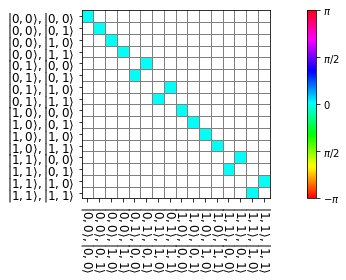

In [9]:
# Gate instructions
#ideal_gate_X2 = qt_utils.np_kron_n([constants.x90p, constants.Id])
#ideal_gate_Unity = qt_utils.np_kron_n([constants.Id, constants.Id])
ideal_gate = custom_gates.GATE_CNOT_t1q2_t2q2
printMatrix(ideal_gate, level_labels, "ideal_gate", output)

gate = gates.Instruction(
    name="cnot_t1q2_t2q2" + ("_pwc" if usePWC else ""),
    targets=[0, 1],
    t_start=0.0,
    t_end=t_final,
    channels=[d.name for d in drives],
    ideal=ideal_gate,
)
for drive in drives:
    for env in envelopes:
        gate.add_component(copy.deepcopy(env), drive.name)
    for carrier in carriers:
        gate.add_component(copy.deepcopy(carrier), drive.name)

In [10]:
# all energy levels with labels
stateEnergies = {}
H = model.get_Hamiltonian()
for i, x in enumerate(level_labels_short):
    if level_labels_short[i] is not None:
        state = np.zeros(model.tot_dim)
        state[i] = 1
        energy = np.vdot(state.T, np.matmul(H, state)).real / (2 * np.pi)
        stateEnergies[energy] = x

# all energy transitions
ordered = OrderedDict(sorted(stateEnergies.items()))
items = list(ordered.items())
transitions = {}
for i in range(len(items)):
    for j in range(i+1, len(items)):
        E = items[j][0] - items[i][0]
        transitions[E] = items[i][1] + " - " + items[j][1]

peaks:  [3.99673328e+09 4.49674161e+09 5.98343306e+09 6.48344139e+09]


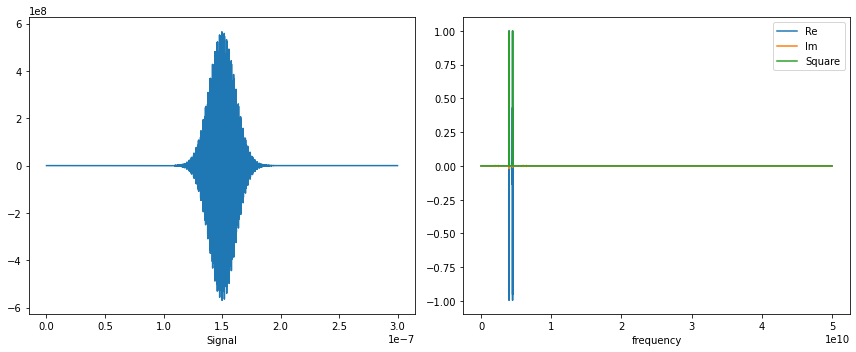

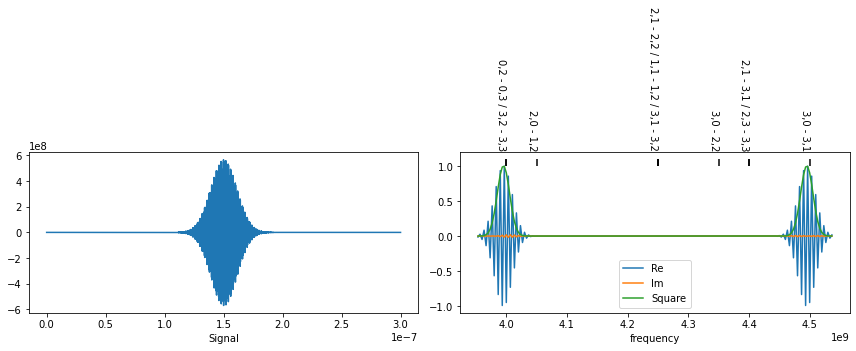

peaks:  [3.99673328e+09 4.49674161e+09 5.98343306e+09 6.48344139e+09]


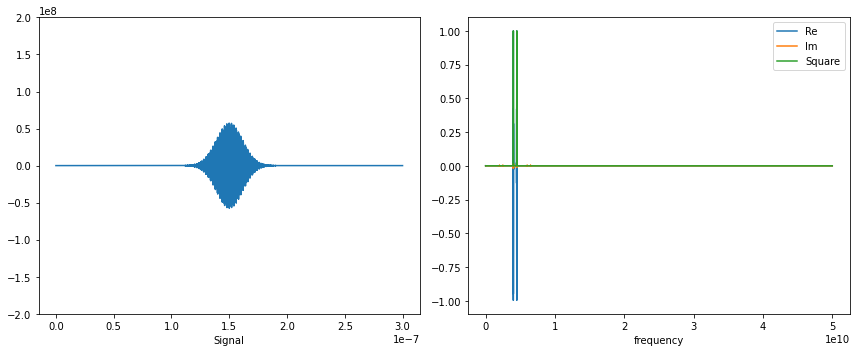

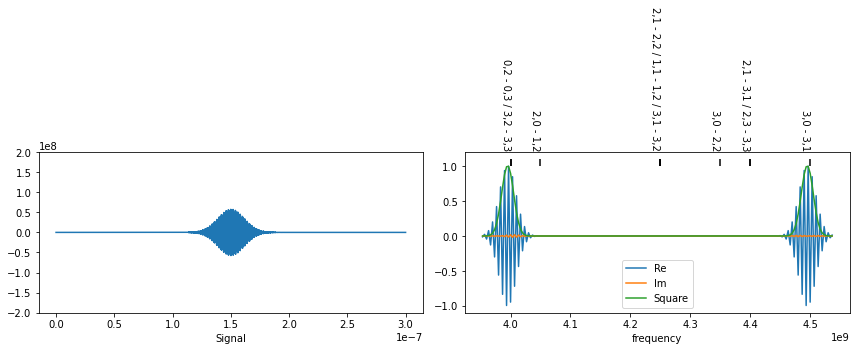

2022-03-28 10:01:48.148845: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 300000000 exceeds 10% of free system memory.
2022-03-28 10:01:48.413567: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 300000000 exceeds 10% of free system memory.
2022-03-28 10:01:48.557080: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 300000000 exceeds 10% of free system memory.
2022-03-28 10:01:48.733531: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 300000000 exceeds 10% of free system memory.
2022-03-28 10:01:48.939760: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 300000000 exceeds 10% of free system memory.


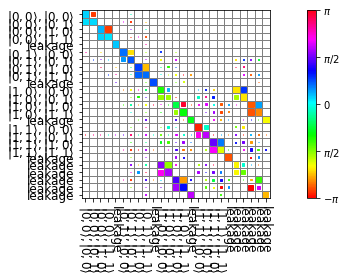

In [11]:
# Set up the experiment
parameter_map = PMap(instructions=[gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates([gate.get_key()])

printSignal(exp, qubits, gate, output=output, states=transitions)

unitaries = exp.compute_propagators()
printPropagator(exp, gate, level_labels_with_leakage, output)

#printAllSignals(exp, qubit, output, directory="devices_before")

In [12]:
'''
M = exp.propagators[gate.get_key()]
M = np.reshape(M, qubit_levels * 2)
M = M[:4, :4, :4, :4]
M = np.reshape(M, [16, 16])
printMatrix(partialTrace(M, [0, 1]) / 2, level_labels_transmon[:4], "partial_trace_A", output)
printMatrix(partialTrace(M, [2, 3]) / 2, level_labels_transmon[:4], "partial_trace_B", output)
'''

'\nM = exp.propagators[gate.get_key()]\nM = np.reshape(M, qubit_levels * 2)\nM = M[:4, :4, :4, :4]\nM = np.reshape(M, [16, 16])\nprintMatrix(partialTrace(M, [0, 1]) / 2, level_labels_transmon[:4], "partial_trace_A", output)\nprintMatrix(partialTrace(M, [2, 3]) / 2, level_labels_transmon[:4], "partial_trace_B", output)\n'

In [13]:
# Specify the initial state
psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = [gate.get_key()]

printTimeEvolution(exp, init_state, gate, level_labels, output)

iswap_t1q2_t2q2[0, 1]


KeyError: 'iswap_t1q2_t2q2[0, 1]'

In [ ]:
# Specify the parameters to be optimised and initialise the optimiser
opt_map = []
for drive in drives:
    for env in envelopesForDrive[drive.name]:
        opt_map.append([(gate.get_key(), drive.name, env.name, "amp")])
        opt_map.append([(gate.get_key(), drive.name, env.name, "freq_offset")])
        opt_map.append([(gate.get_key(), drive.name, env.name, "xy_angle")])
        opt_map.append([(gate.get_key(), drive.name, env.name, "delta")])
        if usePWC:
            opt_map.append([(gate.get_key(), drive.name, env.name, "inphase")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "t_final")])
        else:
            opt_map.append([(gate.get_key(), drive.name, env.name, "sigma")])
    for carrier in carriersForDrive[drive.name]:
        opt_map.append([(gate.get_key(), drive.name, carrier.name, "freq")])
        #opt_map.append([(gate.get_key(), drive.name, carrier.name, "framechange")])
parameter_map.set_opt_map(opt_map)
parameter_map.print_parameters()

In [ ]:
algorithm = algorithms.lbfgs
alg_options = {"maxfun": 1000, "ftol": 1e-6}
'''
algorithm = algorithms.cmaes
alg_options = {
    "popsize": 12,
    "spread": 0.05,
    "maxfevals": 1000,
    "init_point": "True",
    "stop_at_sigma": 1e-3,
    "stop_at_convergence": 20
}
'''
'''
algorithm = algorithms.gcmaes
alg_options = {
    "cmaes": {"popsize": 12, "spread": 0.05, "maxfevals": 1000,
              "init_point": "True", "stop_at_sigma": 1e-3, "stop_at_convergence": 20},
    "lbfgs": {"maxfun": 1000, "ftol": 1e-6}
}
'''

infidelities = optimise(output, qubits, exp, algorithm, alg_options, gate)

In [ ]:
# Plot results
output = DataOutput(output_dir, file_suffix='after')
plotData(np.arange(len(infidelities)), infidelities, xlabel="Step",
         ylabel="Infidelity", filename=output.createFileName("convergence", "png"))
printSignal(exp, qubits, gate, output=output)
#printAllSignals(exp, qubits, output, directory="devices_after")
printPropagator(exp, gate, level_labels_with_leakage, output)
printTimeEvolution(exp, init_state, gate, level_labels, output)
parameter_map.write_config(output.getDirectory() + "/parameter_map_after.json")